# Training SODA encoder

Code for training our implementation of [SODA](https://arxiv.org/abs/2311.17901) encoder on a variation of the [Deepmind's 3D-Shapes Dataset](https://github.com/google-deepmind/3d-shapes).

First, as the authors mention in the paper, the latent representation of the image is derived by a [ResNet](https://arxiv.org/pdf/1512.03385) encoder (Hudson, et al., 2023). in this case we are going to train a **ResNet18 to predict the latent representations of the images dataset**. Our implementation of ResNet is based in the [Pytorch Resnet Module Source Code](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). So we are not using any of the pretrained ResNet models from PuTorch.

## Load Data

To start the training of the network we first load the data from the H5 files.

In [1]:
import os
import h5py
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import itertools

Define data directories.

In [2]:
data_directory: str = "data"
train_file_name: str = "3dshapes_abstraction_train.h5"
test_file_name: str = "3dshapes_abstraction_test.h5"

train_file_path: str = os.path.join(data_directory, train_file_name)
test_file_path: str = os.path.join(data_directory, test_file_name)

_FACTORS_IN_ORDER: list[str] = [
    'floor_hue', 
    'wall_hue', 
    'object_hue', 
    'scale', 
    'shape',                 
    'orientation'
]
_NUM_VALUES_PER_FACTOR: dict[str, int] = {
    'floor_hue': 10, 
    'wall_hue': 10, 
    'object_hue': 10,
    'scale': 8, 
    'shape': 4,
    'orientation': 15
}


Load dataset file contents from H5 files.

In [3]:
train_dataset: h5py.File = h5py.File(train_file_path, 'r')
test_dataset: h5py.File = h5py.File(test_file_path, 'r')

## Encoder Architecture Definition

We use a ResNet18 architecture, trained from scratch, as our encoder.  Instead of the standard classification layer, we replace the final ResNet layer with a fully connected layer. This layer maps the 512-dimensional ResNet output to a lower-dimensional embedding representing the image's attributes: `floor_hue`, `wall_hue`, `object_hue`, `scale`, `shape`, and `orientation`.

In [4]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super(ResNetBlock, self).__init__()

        # Convolutional layer 1
        self.conv1: nn.Conv2d = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False)

        # Batch normalization
        self.bn1: nn.BatchNorm2d = nn.BatchNorm2d(out_channels)

        # Convolutional layer 2
        self.conv2: nn.Conv2d = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False)

        # Batch normalization
        self.bn2: nn.BatchNorm2d = nn.BatchNorm2d(out_channels)

        # ReLU activation function
        self.relu: nn.ReLU = nn.ReLU(inplace=True)

        # Shortcut or skip connection
        self.shortcut: nn.Sequential = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out: torch.Tensor = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [5]:
class ResNet18Encoder(nn.Module):
    def __init__(self, out_features=6):
        super(ResNet18Encoder, self).__init__()
        self.in_channels: int = 64
        self.conv1: nn.Conv2d = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1: nn.BatchNorm2d = nn.BatchNorm2d(64)
        self.relu: nn.ReLU = nn.ReLU(inplace=True)
        self.maxpool: nn.MaxPool2d = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1)

        self.layer1: nn.Sequential = self._make_layer(
            ResNetBlock, 64, 2, stride=1)
        self.layer2: nn.Sequential = self._make_layer(
            ResNetBlock, 128, 2, stride=2)
        self.layer3: nn.Sequential = self._make_layer(
            ResNetBlock, 256, 2, stride=2)
        self.layer4: nn.Sequential = self._make_layer(
            ResNetBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, out_features)

    def _make_layer(self, block, out_channels, num_blocks, stride) -> nn.Sequential:
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out: torch.Tensor = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


Instantiate the data as tensors.

In [6]:
INSTANCES: int = 40_000
TOTAL: int = 480_000

get_instances = lambda x : list(itertools.chain.from_iterable([x[i:i+INSTANCES] for i in range(0, TOTAL//INSTANCES, 2)]))

print("Loading the training data...")
train_images: np.ndarray = torch.tensor(np.transpose(get_instances(train_dataset['images']), (0, 3, 1, 2)))
test_images: np.ndarray = torch.tensor(np.transpose(get_instances(test_dataset['images']), (0, 3, 1, 2)))

print("Loading the test data...")
train_labels: np.ndarray = torch.tensor(get_instances(train_dataset['labels']))
test_labels: np.ndarray = torch.tensor(get_instances(test_dataset['labels']))

Loading the training data...
Loading the test data...


/tmp/ipykernel_319010/2488680182.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_labels: np.ndarray = torch.tensor(get_instances(train_dataset['labels']))


Define relevant parameters for training.

In [7]:
BATCH_SIZE: int = 256
EPOCHS: int = 5
LEARNING_RATE: float = 0.001
DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

Instantiate data loaders.

In [8]:
train_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_images, train_labels),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader: torch.utils.data.DataLoader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_images, test_labels),
    batch_size=BATCH_SIZE, shuffle=False)

Define a training function.

In [11]:
def get_latent_stats(train_loader) -> dict[str, list[float]]:
    latents_all = []
    for _, latents in train_loader:
        latents_all.append(latents.numpy())
    latents_all = np.concatenate(latents_all, axis=0)
    latent_mean = np.mean(latents_all, axis=0)
    latent_std = np.std(latents_all, axis=0)
    latent_std[latent_std == 0] = 1e-6 
    return latent_mean, latent_std

def get_min_max_latents(train_loader) -> dict[str, list[float]]:
    latents_all = []
    for _, latents in train_loader:
        latents_all.append(latents.numpy())
    latents_all = np.concatenate(latents_all, axis=0)
    latent_min = np.min(latents_all, axis=0)
    latent_max = np.max(latents_all, axis=0)
    return latent_min, latent_max

def train_model(model, train_loader, test_loader, EPOCHS, LEARNING_RATE, criterion=nn.CosineEmbeddingLoss(), optimizer_class=torch.optim.Adam, optimizer_params=None) -> dict:
    model.to(DEVICE)
    latent_mean, latent_std = get_latent_stats(train_loader)
    min_latent, max_latent = get_min_max_latents(train_loader)
    max_latent = torch.tensor(max_latent).to(DEVICE)
    min_latent = torch.tensor(min_latent).to(DEVICE)
    print(f'Latent mean: {latent_mean}')
    print(f'Latent std: {latent_std}')
    if optimizer_params is None:
        optimizer_params = {}
    optimizer = optimizer_class(model.parameters(), lr=LEARNING_RATE, **optimizer_params)

    training_metrics = {'loss_per_epoch': [], 'test_loss_per_epoch': [], 'training_time': [], 'mae_per_component': []}

    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        start_time = time.time()

        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (Train)", unit="batch") as tepoch:
            for images, latents in tepoch:
                images = images.to(DEVICE).float() / 255.0
                # latents = (latents.to(DEVICE) - torch.tensor(latent_mean).to(DEVICE)) / torch.tensor(latent_std).to(DEVICE)
                latents = (latents.to(DEVICE) - min_latent) / max_latent - min_latent
                outputs = model(images)
                ones = torch.ones(latents.shape[0]).to(DEVICE)
                loss = criterion(outputs, latents, ones)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        average_epoch_loss = epoch_loss / len(train_loader)
        training_metrics['loss_per_epoch'].append(average_epoch_loss)


        test_loss = 0.0
        mae_per_component = np.zeros(6) # Inicializar MAE para cada componente
        model.eval()
        with torch.no_grad():
            with tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (Test)", unit="batch") as tepoch:
                for images, latents in tepoch:
                    images = images.to(DEVICE).float() / 255.0
                    # latents = (latents.to(DEVICE) - torch.tensor(latent_mean).to(DEVICE)) / torch.tensor(latent_std).to(DEVICE)
                    latents = (latents.to(DEVICE) - min_latent / max_latent - min_latent)
                    outputs = model(images)
                    ones = torch.ones(latents.shape[0]).to(DEVICE)
                    loss = criterion(outputs, latents, ones)
                    test_loss += loss.item()
                    tepoch.set_postfix(loss=loss.item())

                    # Calcular MAE para cada componente
                    mae_per_component += np.mean(np.abs(outputs.cpu().numpy() - latents.cpu().numpy()), axis=0)


        average_test_loss = test_loss / len(test_loader)
        training_metrics['test_loss_per_epoch'].append(average_test_loss)
        training_metrics['mae_per_component'].append(mae_per_component / len(test_loader)) # Agregar MAE promedio por época


        end_time = time.time()
        epoch_time = end_time - start_time
        training_metrics['training_time'].append(epoch_time)

        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {average_epoch_loss:.4f}, Test Loss: {average_test_loss:.4f}, Time: {epoch_time:.2f}s')
        print(f'MAE per component: {training_metrics["mae_per_component"][-1]}') # Imprimir MAE por componente de la época actual

    return training_metrics



Train the model.

In [12]:
model: ResNet18Encoder = ResNet18Encoder(out_features=6)
training_metrics: dict[str, list[float]] = train_model(model, train_loader, test_loader, EPOCHS, LEARNING_RATE)

Latent mean: [4.00125000e-02 3.84075000e-01 4.43475000e-01 9.99669643e-01
 4.99912500e-01 2.67857143e-04]
Latent std: [ 0.04899234  0.26632948  0.28585822  0.16357343  0.49999999 18.516247  ]


Epoch 1/5 (Test): 100%|██████████| 938/938 [00:41<00:00, 22.67batch/s, loss=0.0533]


Epoch [1/5], Train Loss: 0.0025, Test Loss: 0.0493, Time: 171.17s
MAE per component: [ 0.02945368  0.30537668  0.36555864  0.2777411   2.31686422 26.43343537]


Epoch 2/5 (Test): 100%|██████████| 938/938 [00:38<00:00, 24.34batch/s, loss=0.0537]


Epoch [2/5], Train Loss: 0.0000, Test Loss: 0.0496, Time: 164.27s
MAE per component: [ 0.04669061  0.28707898  0.36296397  0.26419483  2.28304247 25.34115972]


Epoch 3/5 (Test): 100%|██████████| 938/938 [00:41<00:00, 22.55batch/s, loss=0.0535]


Epoch [3/5], Train Loss: 0.0000, Test Loss: 0.0492, Time: 158.47s
MAE per component: [ 0.06358673  0.27217042  0.35361997  0.25786105  2.2403758  24.85260036]


Epoch 4/5 (Test): 100%|██████████| 938/938 [00:39<00:00, 23.78batch/s, loss=0.0532]


Epoch [4/5], Train Loss: 0.0000, Test Loss: 0.0488, Time: 166.76s
MAE per component: [ 0.09277824  0.26505615  0.34013517  0.21470508  2.19448217 24.41965026]


Epoch 5/5 (Test): 100%|██████████| 938/938 [00:41<00:00, 22.56batch/s, loss=0.0531]

Epoch [5/5], Train Loss: 0.0000, Test Loss: 0.0487, Time: 160.17s
MAE per component: [ 0.07568441  0.27191582  0.33326057  0.20907131  2.16282884 23.85203244]


In [13]:
def plot_metrics(training_metrics):
    """
    Grafica las métricas de entrenamiento usando Matplotlib.

    Args:
        training_metrics (dict): Diccionario con las métricas de entrenamiento.
    """

    epochs = range(1, len(training_metrics['loss_per_epoch']) + 1)

    # Gráfica de Pérdida de Entrenamiento y Prueba
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_metrics['loss_per_epoch'], label='Train Loss')
    plt.plot(epochs, training_metrics['test_loss_per_epoch'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)


    # Gráfica de MAE por Componente
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.plot(epochs, [epoch_mae[i] for epoch_mae in training_metrics['mae_per_component']], label=_FACTORS_IN_ORDER[i])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error per Component')
    plt.legend()
    plt.grid(True)

    plt.show()

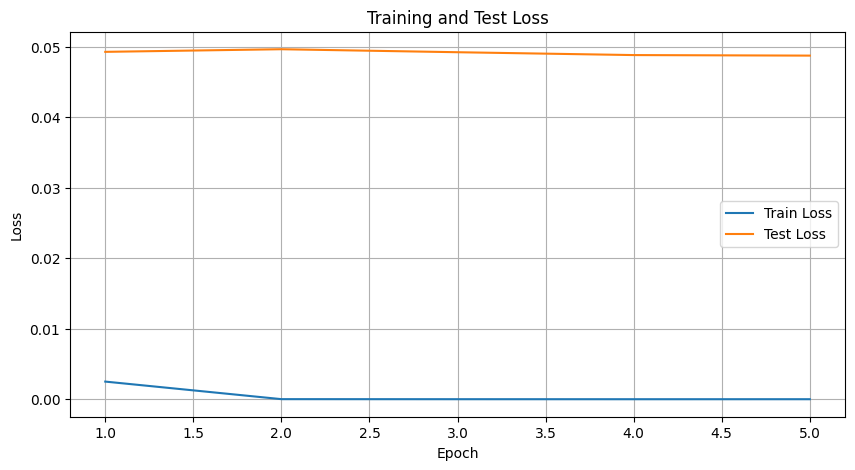

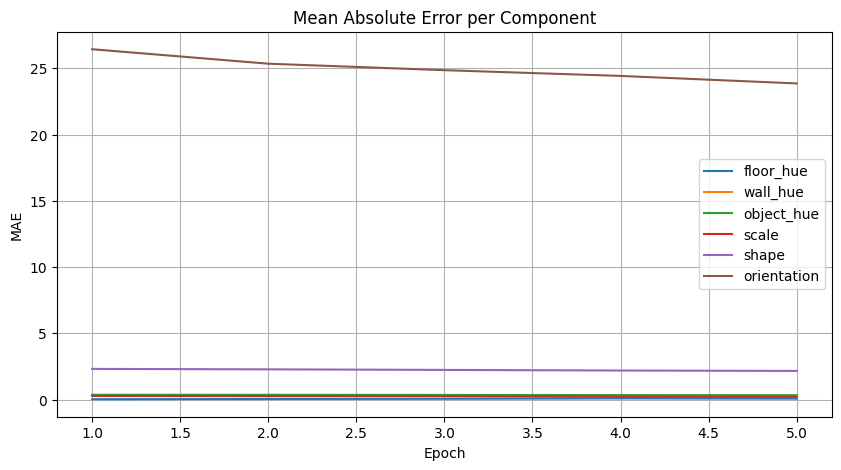

In [14]:
plot_metrics(training_metrics)

In [15]:
# def predict(model, image, latent_mean, latent_std):
def predict(model, image, min_latent, max_latent):
    """
    Realiza una predicción sobre una imagen y desnormaliza el resultado.

    Args:
        model: El modelo entrenado.
        image: La imagen de entrada (tensor).
        latent_mean (torch.Tensor): La media de los latents.
        latent_std (torch.Tensor): La desviación estándar de los latents.

    Returns:
        torch.Tensor: El vector latente predicho y desnormalizado.
    """
    model.eval()
    with torch.no_grad():
        image = torch.tensor(image).to(DEVICE).float() / 255.0
        image = image.permute(2, 0, 1).unsqueeze(0)  # Permutar dimensiones y agregar batch
        predicted_latent_normalized = model(image)
        # predicted_latent = predicted_latent_normalized * torch.tensor(latent_std).to(DEVICE) + torch.tensor(latent_mean).to(DEVICE)
        predicted_latent = predicted_latent_normalized * (torch.tensor(max_latent) - torch.tensor(min_latent)) + torch.tensor
        return predicted_latent

In [16]:
latent_mean, latent_std = get_latent_stats(train_loader)
min_latent, max_latent = get_min_max_latents(train_loader)
min_latent = torch.tensor(min_latent).to(DEVICE)
max_latent = torch.tensor(max_latent).to(DEVICE)
image = test_dataset['images'][0]
# predicted_latent = predict(model, image, latent_mean, latent_std).squeeze()
predicted_latent = predict(model, image, min_latent, max_latent).squeeze()
expected_latent = test_dataset['labels'][0].squeeze()
for i, factor_name in enumerate(_FACTORS_IN_ORDER):
    print(f"{factor_name}: {expected_latent[i]} -> {predicted_latent[i]}")

/tmp/ipykernel_319010/1312107936.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_latent = predicted_latent_normalized * (torch.tensor(max_latent) - torch.tensor(min_latent)) + torch.tensor


TypeError: unsupported operand type(s) for +: 'Tensor' and 'builtin_function_or_method'

In [17]:
def save_metrics_to_csv(training_metrics, filename="training_metrics.csv"):
    """
    Guarda las métricas de entrenamiento en un archivo CSV.

    Args:
        training_metrics (dict): Diccionario con las métricas de entrenamiento.
        filename (str): Nombre del archivo CSV (default: "training_metrics.csv").
    """

    epochs = range(1, len(training_metrics['loss_per_epoch']) + 1)

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Escribir encabezado
        header = ['Epoch', 'Train Loss', 'Test Loss', 'Training Time (s)']
        for i in range(6):
            header.append(f'MAE Component {i+1}')
        writer.writerow(header)

        # Escribir datos por época
        for epoch, train_loss, test_loss, train_time, mae_per_component in zip(
            epochs,
            training_metrics['loss_per_epoch'],
            training_metrics['test_loss_per_epoch'],
            training_metrics['training_time'],
            training_metrics['mae_per_component']
        ):
            row = [epoch, train_loss, test_loss, train_time]
            row.extend(mae_per_component)
            writer.writerow(row)


In [18]:
save_metrics_to_csv(training_metrics)